In [8]:
# 示例代码，使用PyTorch加载预训练的MoCo模型
import torch
import moco.builder
import torchvision.models as models
model = moco.builder.MoCo(models.__dict__["resnet50"],mlp=True)
# 加载预训练的权重
pretrained_weights = torch.load('moco_pre/moco_v2_800ep_pretrain.pth')

model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_weights.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)


<All keys matched successfully>

In [ ]:
# 示例代码，对数据进行预处理
from PIL import Image
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# 示例代码，移除MoCo模型的分类层
features = torch.nn.Sequential(*list(model.children())[:-1])
# 加载图片
image = Image.open("./data/trainA/2-1PZP95206.jpg")
image = preprocess(image).unsqueeze(0)  # 添加一个批次维度


# 定义一个钩子函数，它会打印通过层的数据的形状
def print_shape_hook(module, input, output):
    print(f"Layer: {module.__class__.__name__} Output shape: {output.shape}")

# 遍历模型的所有子模块并为每个层附加钩子
for layer in features.children():
    layer.register_forward_hook(print_shape_hook)
# 使用模型进行推断
# with torch.no_grad():  # 不计算梯度
#     output = features(image)
# print(model)
print(features)

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

class Generator(nn.Module):
    """
    Generator
    """

    def __init__(self):
        super(Generator,self).__init__()


        resnet50 = models.resnet50(pretrained=True)
        # 删除最后的全连接层
        modules = list(resnet50.children())[:-2]

        self.encoder = torch.nn.Sequential(*modules)

    def forward(self, input):
        """Standard forward"""
        return self.encoder(input)



In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.image_paths = root
        self.imgs = self.read_file(self.image_paths)
        self.transform = transform

    def read_file(self, path):
        """从文件夹中读取数据"""
        files_list = os.listdir(path)
        file_path_list = [os.path.join(path, img) for img in files_list]
        file_path_list.sort()  # 如果你需要特定的顺序则保留这一行
        return file_path_list

    def __len__(self):
        return len(self.imgs)  # 返回图片列表的长度

    def __getitem__(self, index):
        image_path = self.imgs[index]  # 使用图片列表中的路径
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image


In [4]:
from torch import nn
from torch.nn import functional as F
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._num_embeddings = num_embeddings
        self._embedding_dim = embedding_dim
        self._commitment_cost = commitment_cost

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1 / self._num_embeddings, 1 / self._num_embeddings)


    def forward(self, inputs,key = None):
        # 传入的是图片经过encoder后的feature maps
        # convert inputs from BCHW
        input_shape = inputs.shape

        
        # Flatten input ->[BC HW]
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input ** 2, dim=1, keepdim=True)
                     + torch.sum(self._embedding.weight ** 2, dim=1)
                     - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #得到编号
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        
        if key == "Content":
            loss = e_latent_loss
        else:
            loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()        

        # convert quantized from BHWC -> BCHW
        return  quantized,loss

torch.Size([1, 3, 256, 256])


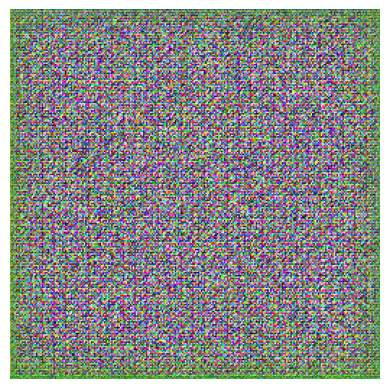

In [5]:
import torch
from torch import nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        # 定义一个上采样层序列，逐步增加特征图的尺寸
        self.upsample = nn.Sequential(
            # 将 2048x8x8 上采样到 1024x16x16
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # 上采样到 512x32x32
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 上采样到 256x64x64
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 上采样到 128x128x128
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 上采样到 64x256x256
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 上采样到 3x512*512
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh() # 使用Tanh激活函数使输出像素值落在[0, 1]范围内
        )

    def forward(self, x):
        # 假设输入的x是一个2048x8x8的特征
        return self.upsample(x)

# 实例化解码器
decoder = Decoder()

# 假设 feature 是一个 (batch_size, 2048, 1, 1) 形状的张量
feature = torch.randn(1, 2048, 8, 8)

# 通过解码器生成图像
output_image = decoder(feature)

print(output_image.shape)  # 应该输出 torch.Size([1, 3, 512, 512])

import matplotlib.pyplot as plt
import numpy as np

# 假设 output_image 是解码器的输出，形状为 [3, 512, 512]
# 将其从 PyTorch Tensor 转换为 NumPy 数组，并且进行归一化
image_np = output_image[0].detach().numpy().transpose(1, 2, 0)
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

# 使用 Matplotlib 显示图像
plt.imshow(image_np)
plt.axis('off')  # 关闭坐标轴
plt.show()


In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.encoder = Generator()
        num_embeddings = 1024 # 嵌入向量数量，过多容易过拟合，过少容易欠拟合
        embedding_dim = 2048*8*8 # 
        commitment_cost = 0.25
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost).cuda()
        self.decoder = Decoder()
        

    def forward(self, x):
        z = self.encoder(x) #
        quantized,loss_vq = self.vq(z)
        x_recon = self.decoder(quantized)
        loss_rec = F.mse_loss(x,x_recon)
        # loss = loss_vq + loss_rec

        return loss_vq , loss_rec, x_recon

In [7]:
from torch import optim


# 定义一个转换操作，比如转换成张量并且归一化
transform = transforms.Compose([transforms.Resize((256, 256)),
                                          transforms.ToTensor()])

train_data_root = "./data/trainA"

# 创建数据集
dataset = CustomDataset(root=train_data_root, transform=transform)

# 创建数据加载器
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Model()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model,device_ids=[0, 1])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)


# 在训练循环中使用数据加载器
for i in range(50000):
    data = next(iter(dataloader)).cuda()
    # 在这里进行你的训练...
    # print(data.shape)
    loss_vq , loss_rec,output_image = model(data)
    loss = loss_vq + loss_rec
    if loss.dim() > 0:  # 检查loss_G是否为标量
            loss = loss.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(i%100==0):
        print(f" VQ_loss : {loss_vq}; rec_loss : {loss_rec}")
    if(i%1000==0):
        # 假设 'model' 是你的神经网络模型实例，'i' 是当前的训练轮数
        torch.save(model.state_dict(), f'./model_weight/1/model_weights_epoch_{i}.pth')


/home/hp/anaconda3/envs/yang/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hp/anaconda3/envs/yang/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


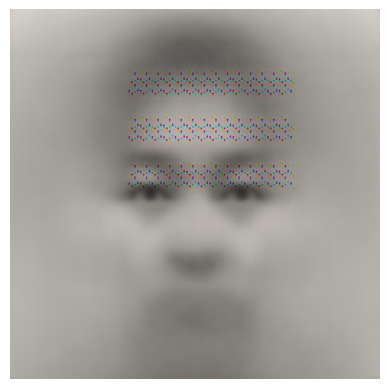

In [14]:
data = next(iter(dataloader)).cuda()
# 加载完整的预训练模型状态字典
full_model_state_dict = torch.load('./model_weight/1/model_weights_epoch_8000.pth')
model.load_state_dict(full_model_state_dict)
loss_vq , loss_rec,output_image = model(data)
image_np = output_image[0].cpu().detach().numpy().transpose(1, 2, 0)
# image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
# image_np = np.clip(image_np, 0.0, 1.0)

# 使用 Matplotlib 显示图像
plt.imshow(image_np)
plt.axis('off')  # 关闭坐标轴
plt.show()